<a href="https://colab.research.google.com/github/dinesh110598/Spin_glass_NN/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Bimodal triangular EA lattices
The Hamiltonian for the EA model on a 2d triangular lattice with spins {S}:

$ H = \displaystyle\sum_{<i,j>} J_{ij}(p).S_iS_j$ where \<ij\> denotes nearest neighbour positions on a triangular lattice and $J_{ij}(p)$ takes values +1 and -1 with probabilities p and 1-p respectively. We'll consider only the values of p between 0.5 and 1 throughout this notebook.

## Classification between p=0.5 and p=0.7
In this subsection, we will supply a convolutional neural network (CNN) with properly labelled samples for p=0.5 and p=0.7, over multiple realisations of couplings $J_{ij}$ in each category. Later, we'll analyse the network's output for intermediate values of p. Following this, we'll look at 2 point correlation functions of these lattices for the same values and compare the variation of correlation functions with that of neural network output. 

### Imports and dependecies

In [ ]:
import math
import numpy as np
import cupy as cp
import tensorflow.keras as tfk
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
from google.colab import output
drive.mount('/content/drive', force_remount=True)
folder_path = "/content/drive/My Drive/Project Presentations/Spin_glass_phase_classification/"

I've written Numba CUDA kernels (functions that perform calculations inside GPUs using CUDA) for simulating MCMC and parallel tempering algorithms for triangular EA model, in a seperate python file. Let's import the file and its contents inside this notebook:

In [ ]:
!curl -o TriEA_kernels.py https://raw.githubusercontent.com/dinesh110598/Spin_glass_NN/master/TriEA_kernels.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6063  100  6063    0     0  14970      0 --:--:-- --:--:-- --:--:-- 14970


In [ ]:
from TriEA_kernels import *

### Data generating function

Let's write a function that uses the imported kernels to generate our training data:

In [ ]:
def generate_train_data (train_len, prob, lat_len=48, m=100):
    shape = (lat_len, lat_len)
    n_ens = train_len//m
    spin = cp.random.choice ([1,-1], (train_len,)+shape).astype(np.int8)
    seed = cp.random.randint (-10000,10000, size=(train_len,)+shape,
                                       dtype=np.int32)
    Jnn = cp.random.choice ([-1,1], (n_ens,)+shape+(3,), 
                                        p=[1-prob, prob]).astype(np.float32)
    energy = cp.zeros ((n_ens,m), np.float32)
    tpb = (1,8,8)
    bpg = (train_len, lat_len//8, lat_len//8)
    temp = 0.5
    T = cp.linspace (temp, temp+2.5, m, dtype=np.float32)
    T = cp.broadcast_to (T, (n_ens,m))
    for _ in range (300):
        for _ in range (4):
            update_red [bpg,tpb] (spin, seed, T, Jnn)
            update_blue [bpg,tpb] (spin, seed, T, Jnn)
            update_green [bpg,tpb] (spin, seed, T, Jnn)
        calc_energy [math.ceil(train_len/64),64] (spin, energy, Jnn)
        parallel_temper2 [math.ceil(train_len/128),64] (T, seed, energy)
    T = cp.full (T.shape, temp, np.float32)
    for _ in range (500):
        update_red [bpg,tpb] (spin, seed, T, Jnn)
        update_blue [bpg,tpb] (spin, seed, T, Jnn)
        update_green [bpg,tpb] (spin, seed, T, Jnn)

    calc_energy [math.ceil(train_len/64),64] (spin, energy, Jnn)
    spin = 0.5*cp.asnumpy (spin)
    return spin[...,np.newaxis]#Additional axis required for conv2d layer

Let's generate training data for p=0.5 and concatenate with that of p=0.7, with corresponding labels 0 and 1 respectively:

In [ ]:
t_lattice = generate_train_data (8000, 0.5)
t_label = np.zeros (8000, np.int32)
t_lattice = np.concatenate ([t_lattice, generate_train_data (8000,0.7)])
t_label = np.concatenate ([t_label, np.ones (8000, np.int32)])

In [ ]:
t_lattice.shape

(16000, 48, 48, 1)

Let's gather our numpy data in a single tf.data dataset

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices ((t_lattice,t_label))
train_data = train_data.shuffle (buffer_size=16000)

Splitting the dataset into training and validation datasets:

In [ ]:
val_data = train_data.take (4000)
train_data = train_data.skip (4000)

In [ ]:
val_data = val_data.batch (16)
train_data = train_data.batch (16)

### Neural network initialization and training:

In [ ]:
brain = tfk. Sequential([
    tfk.layers.Conv2D(64, (2,2), activation='relu', input_shape = (48,48,1)),
    tfk.layers.MaxPool2D (),
    tfk.layers.Conv2D(64, (2,2), activation='relu'),
    tfk.layers.Flatten(),
    tfk.layers.Dense(64, activation='relu'),
    tfk.layers.Dropout(0.3),
    tfk.layers.Dense(2, activation='softmax')
])

In [ ]:
brain.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
hist = brain.fit (train_data, epochs=1, validation_data=val_data)

750/750 [==============================] - 5s 5ms/step - loss: 0.1879 - accuracy: 0.9058 - val_loss: 1.0642e-05 - val_accuracy: 1.0000


### Neural network predictions for intermediate values

In [ ]:
datax = []
t_lattice = []
p = 0.5
while (p < 0.701):
    t_lattice.append (generate_train_data (1000, p))
    datax.append (p)
    p += 0.02
t_lattice = np.concatenate (t_lattice)

In [ ]:
predictions = brain.predict (t_lattice)

In [ ]:
predictions.shape

(11000, 2)

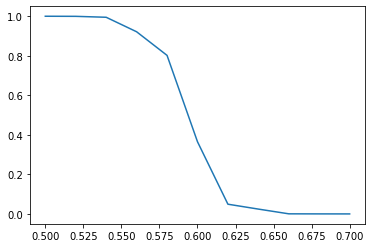

In [ ]:
datay = []
for i in range (11):
    datay.append (predictions[1000*i:1000*(i+1),0].mean())
plt.plot (datax, datay)